In [120]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

df = pd.read_excel(
    r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\ipynb\clinical_biomarker_NF.xlsx"
)

print(df.shape)
df.head()


(1000, 34)


,age,gender,height,weight,occupation,physical_activity_level,living_environment,do_you_currently_experience_knee_pain,pain_score,stiffness,...,does_the_patient_have_any_other_health_conditions_or_risk_factors_that_may_contribute_to_knee_osteoarthritis,what_are_the_suggested_or_ongoing_treatments_for_the_patients_current_condition,koa,does_the_patient_has_obesity,does_the_patient_has_diabetes,does_the_patient_has_hypertension,does_the_patient_has_vitamin_d_deficiency,does_the_patient_has_rheumatoid_arthritis,bmi,koa_grade
0,70.0,Female,1.55,60.0,No,Moderate,Urban,Yes,3.0,Frequently,...,"Obesity or overweight, Family history of osteo...","0 = Lifestyle modification, 1 = Physiotherapy,...",Yes,Yes,No,No,No,No,24.973985,1
1,48.0,Female,1.57,70.0,No,Moderate,Rural,Yes,4.0,Frequently,...,Family history of osteoarthritis,"0 = Lifestyle modification, 1 = Physiotherapy,...",Yes,No,No,No,No,No,28.398718,2
2,54.0,Female,1.58,76.0,No,Moderate,Urban,Yes,3.0,Never,...,"Vitamin D deficiency, Sedentary or low-activit...","0 = Lifestyle modification, 1 = Physiotherapy,...",Yes,No,No,No,Yes,No,30.443839,3
3,52.0,Female,1.55,60.0,No,Low,Urban,Yes,2.0,Occasionally,...,None of the above,"2 = Medication,",Yes,No,No,No,No,No,24.973985,1
4,74.0,Female,1.55,63.0,No,Moderate,Urban,Yes,2.0,Occasionally,...,Vitamin D deficiency,2 = Medication,Yes,No,No,No,Yes,No,26.222685,1


In [121]:
TARGET = "koa_grade"

X = df.drop(columns=[TARGET, "koa_severity"])
y = df[TARGET]

print(X.shape, y.shape)


(1000, 32) (1000,)


In [122]:
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['age', 'height', 'weight', 'pain_score', 'fbs', 'wbc', 'platelets', 'cs', 'cholesterol', 'crp', 'esr', 'rf', 'fbc', 'bmi']
Categorical columns: ['gender', 'occupation', 'physical_activity_level', 'living_environment', 'do_you_currently_experience_knee_pain', 'stiffness', 'have_you_had_any_previous_knee_injuries_(acl_tear,_meniscus_tear,_fracture,_etc.)', 'do_you_experience_swelling_in_your_knees', 'do_you_find_difficulty_in_performing_these_activities_(check_all_that_apply)', 'do_you_have_a_family_history_of_osteoarthritis', 'does_the_patient_have_any_other_health_conditions_or_risk_factors_that_may_contribute_to_knee_osteoarthritis', 'what_are_the_suggested_or_ongoing_treatments_for_the_patients_current_condition', 'koa', 'does_the_patient_has_obesity', 'does_the_patient_has_diabetes', 'does_the_patient_has_hypertension', 'does_the_patient_has_vitamin_d_deficiency', 'does_the_patient_has_rheumatoid_arthritis']


In [123]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_maps = {
    "stiffness": ["never", "occasionally", "frequently", "always"]
}

for col, order in ordinal_maps.items():
    if col in X.columns:
        X[col] = pd.Categorical(X[col], categories=order, ordered=True).codes


In [124]:
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


In [125]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


In [126]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.20,
    stratify=y_trainval,
    random_state=42
)


Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=1,                 # ↓ from 7
    min_samples_split=15,        # ↑ from 3
    min_samples_leaf=10,          # ↑ from 2
    max_features="sqrt",         # restrict features per split
    bootstrap=True,
    oob_score=True,              # optional (generalization estimate)
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=1,
                       min_samples_leaf=10, min_samples_split=15,
                       n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=42)

In [128]:
rf_train_pred = rf.predict(X_train)
rf_train_acc = accuracy_score(y_train, rf_train_pred)

print("Random Forest - Training Accuracy: {:.2f}%".format(rf_train_acc * 100))


Random Forest - Training Accuracy: 87.19%


In [129]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Classes in y_test:", sorted(y_test.unique()))
print("All possible classes:", sorted(y.unique()))


y_pred_rf = rf.predict(X_test)

print("Random Forest - Test Accuracy:",
      accuracy_score(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Classes in y_test: [0, 1, 2, 3, 4]
All possible classes: [0, 1, 2, 3, 4]
Random Forest - Test Accuracy: 0.855

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.67      1.00      0.80        30
           2       0.95      0.67      0.79        52
           3       0.85      0.88      0.86        65
           4       0.93      0.76      0.84        17

    accuracy                           0.85       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.88      0.85      0.85       200



In [130]:
rf_val_pred = rf.predict(X_val)
rf_val_acc = accuracy_score(y_val, rf_val_pred)

print("Random Forest - Validation Accuracy: {:.2f}%".format(rf_val_acc * 100))


Random Forest - Validation Accuracy: 86.25%


In [131]:
from sklearn.metrics import accuracy_score, log_loss

# Predictions
y_train_pred = rf.predict(X_train)
y_val_pred   = rf.predict(X_val)

y_train_prob = rf.predict_proba(X_train)
y_val_prob   = rf.predict_proba(X_val)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc   = accuracy_score(y_val, y_val_pred)

# Loss (Log Loss)
train_loss = log_loss(y_train, y_train_prob)
val_loss   = log_loss(y_val, y_val_prob)

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)

print("Train Loss:", train_loss)
print("Validation Loss:", val_loss)


Train Accuracy: 0.871875
Validation Accuracy: 0.8625
Train Loss: 1.342847622740899
Validation Loss: 1.3481134855884838


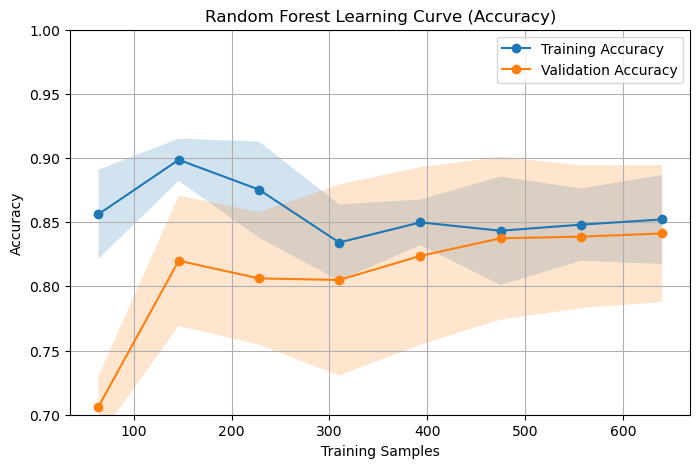

In [134]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, learning_curve

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes = np.linspace(0.1, 1.0, 8)

train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=rf,
    X=X_trainval,
    y=y_trainval,
    train_sizes=train_sizes,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes_abs, train_mean, marker="o", label="Training Accuracy")
plt.plot(train_sizes_abs, val_mean, marker="o", label="Validation Accuracy")

plt.fill_between(train_sizes_abs, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes_abs, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("Random Forest Learning Curve (Accuracy)")
plt.ylim(0.70, 1.0)
plt.grid(True)
plt.legend()
plt.show()


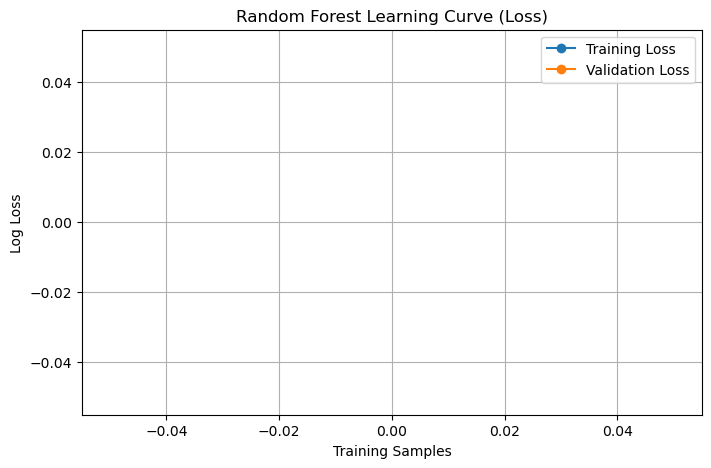

In [136]:
from sklearn.metrics import make_scorer, log_loss

def neg_log_loss_scorer(estimator, X, y):
    prob = estimator.predict_proba(X)
    return -log_loss(y, prob)

logloss_scorer = make_scorer(neg_log_loss_scorer, greater_is_better=True)

train_sizes_abs, train_loss_scores, val_loss_scores = learning_curve(
    estimator=rf,
    X=X_trainval,
    y=y_trainval,
    train_sizes=train_sizes,
    cv=cv,
    scoring=logloss_scorer,
    n_jobs=-1
)

train_loss_mean = (-train_loss_scores).mean(axis=1)
val_loss_mean   = (-val_loss_scores).mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes_abs, train_loss_mean, marker="o", label="Training Loss")
plt.plot(train_sizes_abs, val_loss_mean, marker="o", label="Validation Loss")

plt.xlabel("Training Samples")
plt.ylabel("Log Loss")
plt.title("Random Forest Learning Curve (Loss)")
plt.grid(True)
plt.legend()
plt.show()


Loaded df shape: (1000, 34)
Target distribution:
 0    178
1    150
2    262
3    325
4     85
Name: count, dtype: int64

After dropping features: (1000, 26)
Dropped extras: []

Numeric cols: 13
Categorical cols: 13

==================== ACCURACY ====================
Train Accuracy: 0.8516
Val   Accuracy: 0.8438
Test  Accuracy: 0.8250

==================== TEST REPORT ====================
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.94      0.57      0.71        30
           2       0.97      0.63      0.77        52
           3       0.67      0.98      0.80        65
           4       1.00      0.88      0.94        17

    accuracy                           0.82       200
   macro avg       0.91      0.81      0.84       200
weighted avg       0.87      0.82      0.82       200


==================== CONFUSION MATRIX ====================
[[36  0  0  0  0]
 [ 0 17  0 13  0]
 [ 1  0 33 18  0]
 [ 0 

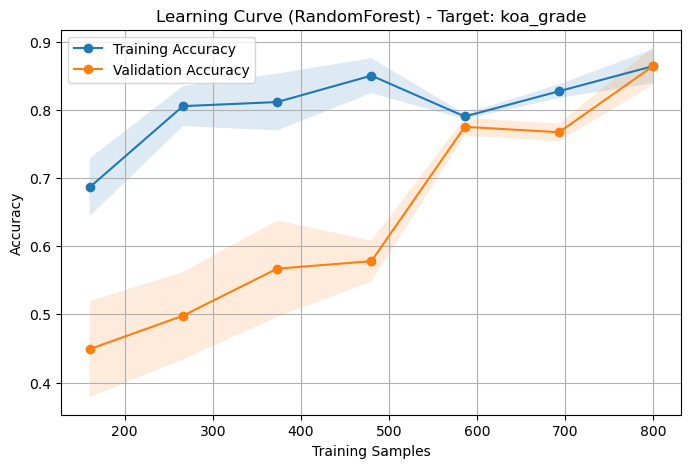

In [140]:
# ============================================================
# RandomForest: Drop features → Train (target 0.80–0.90) →
# Accuracies + CV + Learning Curve → Save .pkl
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


# =========================
# 0) LOAD EXCEL
# =========================
DATA_PATH = r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\ipynb\clinical_biomarker_NF.xlsx"
df = pd.read_excel(DATA_PATH, sheet_name=0)

TARGET_COL = "koa_grade"   # your confirmed target
y = df[TARGET_COL].astype(int).to_numpy()
X = df.drop(columns=[TARGET_COL]).copy()

print("Loaded df shape:", df.shape)
print("Target distribution:\n", pd.Series(y).value_counts().sort_index())


# =========================
# 1) DROP FEATURES (your requested + leakage control)
# =========================
# ✅ Always drop these (your request + leakage columns)
DROP_COLS = [
    "fbc",
    "does_the_patient_has_rheumatoid_arthritis",
    "does_the_patient_has_vitamin_d_deficiency",
    "do_you_have_a_family_history_of_osteoarthritis",
    "living_environment",
    "koa",          # leakage protection
    "koa_severity"  # leakage protection
]

# ✅ OPTIONAL extra drops (use these to push accuracy down into 0.80–0.90 if still too high)
# Start with [] (empty). If accuracy still >0.90, try adding "pain_score", then "crp", then "esr".
EXTRA_DROP = [
    # "pain_score",
    # "crp",
    # "esr",
    # "rf",
    # "bmi"
]

X = X.drop(columns=[c for c in (DROP_COLS + EXTRA_DROP) if c in X.columns], errors="ignore")
print("\nAfter dropping features:", X.shape)
print("Dropped extras:", [c for c in EXTRA_DROP if c in df.columns])


# =========================
# 2) COLUMN TYPES
# =========================
num_cols = X.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))


# =========================
# 3) PREPROCESSOR (inside pipeline)
# =========================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)


# =========================
# 4) RANDOMFOREST (WEAKENED to target 0.80–0.90)
# =========================
# These settings reduce capacity + add randomness.
rf = RandomForestClassifier(
    n_estimators=80,          # ↓ fewer trees
    max_depth=1,              # ↓ shallow trees
    min_samples_split=25,     # ↑ harder splits
    min_samples_leaf=15,      # ↑ conservative leaves
    max_features=0.45,        # ↑ randomness
    bootstrap=True,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)


model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf)
])


# =========================
# 5) TRAIN / VAL / TEST
# =========================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, stratify=y_trainval, random_state=42
)

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_val   = model.predict(X_val)
pred_test  = model.predict(X_test)

train_acc = accuracy_score(y_train, pred_train)
val_acc   = accuracy_score(y_val, pred_val)
test_acc  = accuracy_score(y_test, pred_test)

print("\n==================== ACCURACY ====================")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val   Accuracy: {val_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}")

print("\n==================== TEST REPORT ====================")
print(classification_report(y_test, pred_test, zero_division=0))

print("\n==================== CONFUSION MATRIX ====================")
print(confusion_matrix(y_test, pred_test))


# =========================
# 6) 5-FOLD CV
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

print("\n==================== 5-FOLD CV ====================")
print("Scores:", np.round(cv_scores, 4))
print(f"Mean: {cv_scores.mean():.4f}")
print(f"Std : {cv_scores.std():.4f}")
print(f"Min/Max: {cv_scores.min():.4f} / {cv_scores.max():.4f}")


# =========================
# 7) LEARNING CURVE
# =========================
train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.2, 1.0, 7),
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

print("\n==================== LEARNING CURVE VALUES ====================")
for i in range(len(train_sizes_abs)):
    print(f"Train size={train_sizes_abs[i]:>5}: "
          f"TrainAcc={train_mean[i]:.4f}±{train_std[i]:.4f} | "
          f"ValAcc={val_mean[i]:.4f}±{val_std[i]:.4f}")

plt.figure(figsize=(8,5))
plt.plot(train_sizes_abs, train_mean, marker="o", label="Training Accuracy")
plt.plot(train_sizes_abs, val_mean, marker="o", label="Validation Accuracy")
plt.fill_between(train_sizes_abs, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.fill_between(train_sizes_abs, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.title("Learning Curve (RandomForest) - Target: koa_grade")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()





In [142]:
# =========================
# 8) SAVE MODEL AS .PKL (full pipeline)
# =========================
SAVE_DIR = r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_PATH = os.path.join(SAVE_DIR, "koa_grade_random_forest_newly.pkl")
joblib.dump(model, MODEL_PATH)

print(f"\n✅ Saved pipeline model to:\n{MODEL_PATH}")


✅ Saved pipeline model to:
C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\saved_models\koa_grade_random_forest_newly.pkl
